In [1]:
import rebound
import scipy.integrate as integrate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D

In [3]:
def plotDensityMass(distance, density, mass, figsize = (8, 4.5)):
    fig, ax1 = plt.subplots(figsize = figsize)
    ax2 = ax1.twinx()

    ax1.set_xlabel('Distance from center (kpc)')
    ax1.set_ylabel('Density', color = 'b')
    ax1.tick_params('y', colors = 'b')

    ax2.set_ylabel(r'Mass ($1\times10^5$ $M_\theta$)', color = 'g')
    ax2.tick_params('y', colors = 'g')

    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax2.set_yscale('log')
    
    ax1.plot(distance, density, c = 'b')
    ax2.plot(distance, mass, c = 'g')

    return fig, (ax1, ax2)

# Natural units

$m \rightarrow 10^5 M_{\theta}$

$t \rightarrow 1 \text{ Gyr}$

$d \rightarrow 1 \text{ kpc}$

$$
    G = G_0 \left(\dfrac{1 \text{ kpc}^3}{\left(3.0857\times10^{19}\right)^3  \text{ m}^3}\right)\left(\dfrac{\left(3.154\times10^{16}\right)^2 \text{ s}^2}{1 \text{ Gyr}^2}\right)\left(\dfrac{1.98847\times10^{35} \text{ kg}}{10^5 M_\theta}\right)
$$

In [4]:
kpc = 1 / (3.0857e19 ** 3)
gyr = (3.154e16) ** 2
m0 = (1.98847e35)

G0 = 6.67408e-11
G = G0 * kpc * gyr * m0
G

0.4493375652451876

$$
    H = H_0 \left(\dfrac{1 \text{ kpc}}{3.0857\times10^{16} \text{ km}}\right)\left(\dfrac{1 \text{ s}}{3.154\times10^{13} \text{ Gyr}}\right)\left(\dfrac{1 \text{ Mpc}}{1000 \text{ kpc}}\right)
$$

In [5]:
H_0 = 67.66
kpc2 = 1 / (3.0857e16) # 1 kpc in km
gyr2 = 3.154e13
H = H_0 * kpc2 * gyr2 / 1000
H

6.915761091486533e-05

# Rebound simulation
The force for a single body will be given by:
$$
    \ddot{\vec{x}} = \left(-\dfrac{GM_h(x)}{x^2} + a_{DF} - \dot x\dfrac{\dot M_\bullet}{M_\bullet} - qH^2x\right)\hat{x}
$$

## Mass

The host is modeled has a spherically symmetric potential composed of a dark matter halo and a baryonic profile.

In [6]:
SOLAR_MASS = 1e-5
DARK_MATTER_DENSITY_0 = 1
DARK_MATTER_SCALE_RADIUS = 1

## Dark matter halo

For a dark matter halo following a NFW profile, the density at some distance $r$ is given by the formula:
$$
    \rho_\text{DM}(r) = \dfrac{\rho_0^\text{DM}}{\frac{r}{R_s}\left(1 + \frac{r}{R_s}\right)^2}
$$

Where $R_s$ and $\rho_0$ are constants for a galaxy.

The cumulative mass within some radius $r$ is:
$$
    M_{DM} = \int\limits_0^{r} 4\pi {r'}^2\rho_\text{DM}(r')dr' = 4\pi\rho_0R_s^3\left[\ln\left(\dfrac{R_s + r}{R_s}\right) - \dfrac{r}{R_s + r}\right]
$$

Since the mass of dark matter of a single galaxy diverges for $r \rightarrow \infty$ there is a radius called $R_\text{vir}$, at which the density of the NFW profile is 200 times the critical density $\rho_\text{crit}$ the minimum density for an expanding universe.
$$
    R_\text{vir} = 200 \rho_\text{crit} = 200 \left(\dfrac{3H^2}{8\pi G}\right)
$$

Considering a concentration parameter $c(M_h, z)$ of dark matter in the halo, given by:
$$
    c(M_h, z) = c_0(z)\left(\dfrac{M_h}{10^{13}M_\theta}\right)^{\alpha(z)} \qquad \text{where $z$ is the redshift}
$$

where $\alpha(z)$ and $c_0(z)$ were fitted using simulation data to the following functions:
$$
    c_0(z) = \dfrac{4.58}{2}\left[\left(\dfrac{1 + z}{2.24}\right)^{0.107} + \left(\dfrac{1 + z}{2.24}\right)^{-1.29}\right]
$$

$$
    \alpha(z) = -0.0965 \exp\left(-\dfrac{z}{4.06}\right)
$$

The concentration parameter of dark matter relates the viral radius $R_\text{vir}$ and the scale radius $R_s$ as:
$$
    R_\text{vir} = c(M_h, z)R_s
$$

In [7]:
def darkMatterDensity(r):
    global DARK_MATTER_DENSITY_0, DARK_MATTER_SCALE_RADIUS
    
    factor = r / DARK_MATTER_SCALE_RADIUS
    return DARK_MATTER_DENSITY_0 / (factor * (1 + factor) ** 2)

def darkMatterMass(r):
    global DARK_MATTER_DENSITY_0, DARK_MATTER_SCALE_RADIUS
    factor = np.log(1 + r / DARK_MATTER_SCALE_RADIUS) - r / (DARK_MATTER_SCALE_RADIUS + r)
    return 4 * np.pi * DARK_MATTER_DENSITY_0 * factor * DARK_MATTER_SCALE_RADIUS ** 3

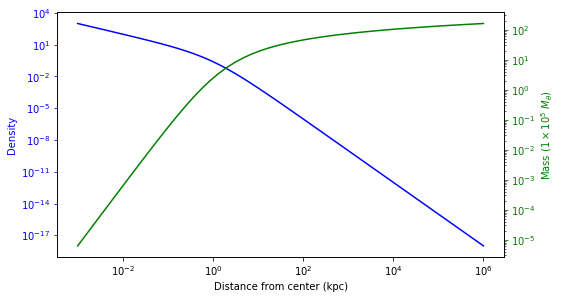

In [8]:
r = np.logspace(-3, 6)

ds = darkMatterDensity(r)
ms = darkMatterMass(r)

fig, (ax1, ax2) = plotDensityMass(r, ds, ms)
fig.savefig('NFW_profile.png', dpi = 300)
plt.show()

## Concentration of dark matter halo

$$
    c(M_h, z) = c_0(z)\left(\dfrac{M_h}{10^{13}M_\theta}\right)^{\alpha(z)}
$$

$$
    c_0(z) = \dfrac{4.58}{2}\left[\left(\dfrac{1 + z}{2.24}\right)^{0.107} + \left(\dfrac{1 + z}{2.24}\right)^{-1.29}\right]
$$

$$
    \alpha(z) = -0.0965 \exp\left(-\dfrac{z}{4.06}\right)
$$

In [9]:
def darkMatterConcentration(mh, z):
    global SOLAR_MASS
    
    c_0 = (4.58 / 2) * (((1 + z) / 2.24) ** 0.107 + ((1 + z) / 2.24) ** -1.29)
    alpha = -0.0965 * np.exp(- z / 4.06)
    factor = mh / (1e13 * SOLAR_MASS)
    return c_0 * factor ** alpha

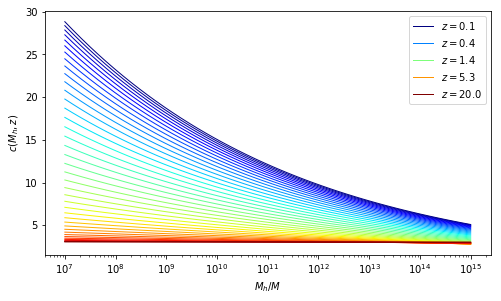

In [10]:
n = 41
every = n // 4
mhs = np.logspace(2, 10)
nmhs = mhs / SOLAR_MASS
zs = np.logspace(-1, 1.3, n)

fig = plt.figure(figsize = (8, 4.5))
ax = fig.gca()

colors = cm.jet(np.linspace(0, 1, n))

for i in range(n):
    c = colors[i]
    dm = darkMatterConcentration(mhs, zs[i])
    
    if i % every == 0:  ax.plot(nmhs, dm, c = c, lw = 1, label = '$z = %.1f$' % zs[i])
    else: ax.plot(nmhs, dm, c = c, lw = 1)
    
ax.set_xscale('log')
ax.set_xlabel('$M_h/M$')
ax.set_ylabel('$c(M_h, z)$')

ax.legend()

fig.savefig('darkmatter_concentration.png', dpi = 300)

plt.show()

# Baryonic mass
## $Z >> 0$
Host’s baryonic mass is gaseous, following an $r^{−2.2}$ density profile with a 1 pc central core of constant density.

$$
    \rho(r) = \left \{
    \begin{matrix}
        \rho_0 \qquad \text{if $r < 1$ pc}\\
        \dfrac{\rho_0}{r^{2.2}} \qquad \text{if $r \geq 1$ pc}\\
    \end{matrix}
    \right.
$$

$$
    M(r) = \left \{
    \begin{matrix}
        \dfrac{4}{3}\pi\rho_0r^3 \qquad \text{if $r < 1$ pc}\\
        4\pi\rho_0r^{0.8} \qquad \text{if $r \geq 1$ pc}\\
    \end{matrix}
    \right.
$$

In [11]:
BARIONIC_DENSITY_0 = 1

def baryonicDensityOld(r):
    def f1(r):
        global BARIONIC_DENSITY_0
        return BARIONIC_DENSITY_0
    def f2(r):
        global BARIONIC_DENSITY_0
        return BARIONIC_DENSITY_0 * r ** (-2.2)
    try:
        if r < 1:
            return f1(r)
        else:
            return f2(r) 
    except ValueError:
        answer = np.zeros_like(r)
        answer[r < 1] = f1(r [r < 1])
        answer[r >= 1] = f2(r[r >= 1])
        return answer

def baryonicMassOld(r):
    global BARIONIC_DENSITY_0
    def f1(r):
        global BARIONIC_DENSITY_0
        return (4 / 3) * np.pi * BARIONIC_DENSITY_0 * r ** 3
    def f2(r):
        global BARIONIC_DENSITY_0
        return 4 * np.pi * BARIONIC_DENSITY_0 * r ** 0.8
    
    try:
        if r < 1e-3:
            return f1(r)
        else:
            return f2(r) 
    except ValueError:
        answer = np.zeros_like(r)
        answer[r < 1e-3] = f1(r [r < 1e-3])
        answer[r >= 1e-3] = f2(r[r >= 1e-3])
        return answer

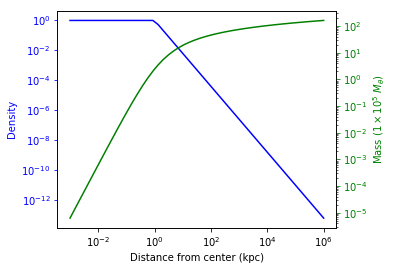

In [12]:
ds = baryonicDensityOld(r)
dm = baryonicMassOld(r)

fig, (ax1, ax2) = plotDensityMass(r, ds, ms, figsize = (5, 4))
fig.savefig("gaseous.png", dpi = 300)
plt.show()

## $Z \approx 0$

$$
    \rho(r) = M_t\dfrac{R_s}{2\pi r(r + R_s)^3}
$$

$$
    M(r) = M_t\dfrac{r^2}{(r + R_s)^2}
$$

$$
    r_{1/2} = \left(1 + \sqrt{2}\right)R_s
$$

In [13]:
TOTAL_MASS = 1e3
SCALE_LENGTH = 1

def baryonicDensityHernquist(r):
    global TOTAL_MASS, SCALE_LENGTH
    return TOTAL_MASS * SCALE_LENGTH / (2 * np.pi * r * (r + SCALE_LENGTH)**3)

def baryonicMassHernquist(r):
    global TOTAL_MASS, SCALE_LENGTH
    return TOTAL_MASS * (r / (r + SCALE_LENGTH))**2

In [14]:
ds = baryonicDensityHernquist(r)
ms = baryonicMassHernquist(r)

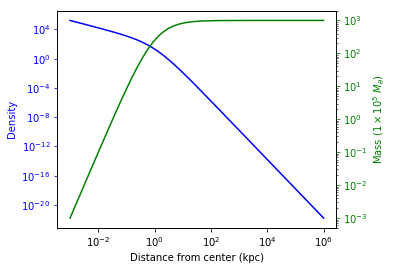

In [15]:
fig, (ax1, ax2) = plotDensityMass(r, ds, ms, figsize = (5, 4))
fig.savefig("hernquist.png", dpi = 300)
plt.show()